# 3교시 RNN/LSTM 시계열 딥러닝 템플릿 (복붙 완전체)
토이데이터 + 문제 흐름 + 모범답안 + 실무 플레이북(불균형/정책/해석) 포함.

## ✅ 이 노트북이 커버하는 2가지 출제 케이스
- **A. 시계열 예측(회귀)**: 미래 KPI/변수 예측 (MAE/RMSE)
- **B. 시계열 이벤트/이상 분류(이진)**: 윈도우 단위로 이상(0/1) 예측 (PR-AUC/F1 + 임계값 정책)

> 시험장에서 할 일: `CSV_PATH`, `time_col`, `target_col`, `exog_cols`, `TASK`만 바꾸면 됨.


## 0) Imports & 재현성

In [1]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
SEED=42
random.seed(SEED); np.random.seed(SEED)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) 토이데이터 생성 (시험장에서는 CSV 로딩으로 대체)

### 컨셉
- 날짜 단위 KPI + 외생변수 (온도/습도/부하/에러)
- 추세 + 주간 계절성 + 이벤트 스파이크
- (옵션) 이벤트 발생일을 이상(1)로 라벨링해서 이진 분류도 가능


In [2]:
def make_toy_ts(n_days=900, seed=42):
    rng=np.random.default_rng(seed)
    date=pd.date_range("2023-01-01", periods=n_days, freq="D")
    temp = 20 + 10*np.sin(2*np.pi*np.arange(n_days)/365) + rng.normal(0,1.5,n_days)
    humidity = 45 + 8*np.sin(2*np.pi*np.arange(n_days)/30) + rng.normal(0,2.0,n_days)
    load = 100 + 5*np.sin(2*np.pi*np.arange(n_days)/7) + rng.normal(0,3.0,n_days)
    error_cnt = rng.poisson(2.0,n_days)

    # 이벤트(희귀): 스파이크 + error_cnt 급증
    event = (rng.random(n_days) < 0.03).astype(int)
    error_cnt = error_cnt + event*rng.poisson(12, n_days)

    trend = 0.02*np.arange(n_days)
    weekly = 3*np.sin(2*np.pi*np.arange(n_days)/7)
    kpi = (
        50 + trend + weekly
        + 0.7*error_cnt
        + 0.15*(load-100)
        + 0.25*(temp-20)
        + rng.normal(0,2.0,n_days)
    )
    # 이벤트일 KPI 더 튐
    kpi = kpi + event*rng.normal(10,3,n_days)

    df=pd.DataFrame({
        "date": date,
        "temp": temp,
        "humidity": humidity,
        "load": load,
        "error_cnt": error_cnt,
        "kpi": kpi,
        "event": event
    })

    # 결측(2%)
    miss = rng.random(n_days) < 0.02
    df.loc[miss, "kpi"] = np.nan
    for c in ["temp","humidity"]:
        m = rng.random(n_days) < 0.01
        df.loc[m, c] = np.nan

    return df

df = make_toy_ts()
df.head()


,date,temp,humidity,load,error_cnt,kpi,event
0,2023-01-01,20.457076,45.779383,99.880881,0,49.987970,0
1,2023-01-02,18.612157,46.868400,105.236521,1,54.566361,0
2,2023-01-03,21.469893,47.959008,103.961359,5,57.519181,0
3,2023-01-04,21.927044,52.878834,100.940472,2,53.633691,0
4,2023-01-05,17.761471,49.700744,98.107643,3,53.481685,0


## 2) 설정: 과제 유형 선택
- `TASK="regression"`: 미래 KPI 예측 (기본)
- `TASK="binary"`: 이벤트/이상(0/1) 예측

> 실제 시험 데이터에 event 라벨이 없으면 대개 regression입니다.


In [3]:
# ===== 시험장에서 바꾸는 곳 =====
CSV_PATH = None  # 예: "/content/your.csv"  (None이면 토이데이터 사용)
time_col = "date"
target_col_reg = "kpi"
target_col_bin = "event"
exog_cols = ["temp","humidity","load","error_cnt"]

TASK = "regression"  # "regression" or "binary"

# ===== 로딩 =====
if CSV_PATH is not None:
    df = pd.read_csv(CSV_PATH)

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.sort_values(time_col).reset_index(drop=True)

target_col = target_col_reg if TASK=="regression" else target_col_bin
print("TASK:", TASK, "target_col:", target_col)
print(df[[time_col]+exog_cols+[target_col]].head())


TASK: regression target_col: kpi
        date       temp   humidity        load  error_cnt        kpi
0 2023-01-01  20.457076  45.779383   99.880881          0  49.987970
1 2023-01-02  18.612157  46.868400  105.236521          1  54.566361
2 2023-01-03  21.469893  47.959008  103.961359          5  57.519181
3 2023-01-04  21.927044  52.878834  100.940472          2  53.633691
4 2023-01-05  17.761471  49.700744   98.107643          3  53.481685


## 3) EDA: 기간/결측/추세 확인

Shape: (900, 7)
Date range: 2023-01-01 00:00:00 -> 2025-06-18 00:00:00
Missing ratio:
 kpi          0.010000
temp         0.008889
humidity     0.010000
load         0.000000
error_cnt    0.000000
dtype: float64


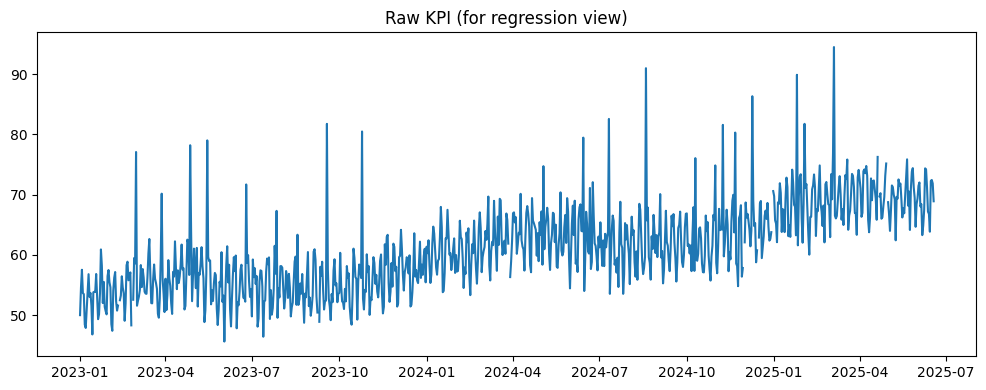

In [4]:
print("Shape:", df.shape)
print("Date range:", df[time_col].min(), "->", df[time_col].max())
print("Missing ratio:\n", df[[target_col]+exog_cols].isna().mean())

plt.figure(figsize=(10,4))
plt.plot(df[time_col], df[target_col_reg], label="kpi")
plt.title("Raw KPI (for regression view)")
plt.tight_layout()
plt.show()

if TASK=="binary":
    print("Event ratio:", df[target_col_bin].mean())


## 4) 결측/이상치 처리 (안전한 기본형)
- 시계열은 time interpolation을 쓰려면 **DatetimeIndex**가 필요합니다.
- 외생변수(exog)에 NaN이 있으면 모델이 쉽게 깨질 수 있어 같이 처리합니다.


In [5]:
dfp = df.copy()
dfp[time_col] = pd.to_datetime(dfp[time_col], errors="coerce")
dfp = dfp.sort_values(time_col).reset_index(drop=True)

# DatetimeIndex로 보간
dfp = dfp.set_index(time_col)

cols_fill = [target_col_reg] + exog_cols
for c in cols_fill:
    dfp[c] = dfp[c].interpolate(method="time")
    dfp[c] = dfp[c].ffill().bfill()

# (옵션) KPI 이상치 클리핑
USE_CLIP = True
if USE_CLIP:
    lo, hi = np.percentile(dfp[target_col_reg].values, [0.5, 99.5])
    dfp[target_col_reg] = dfp[target_col_reg].clip(lo, hi)

dfp = dfp.reset_index()

print("Any NaN left?\n", dfp[[target_col_reg]+exog_cols].isna().any())


Any NaN left?
 kpi          False
temp         False
humidity     False
load         False
error_cnt    False
dtype: bool


## 5) 시계열 윈도우링(슬라이딩 윈도우) 설계

### 핵심
- 입력 X: 과거 `LOOKBACK` 길이의 시계열(외생 포함)
- 타깃 y:
  - 회귀: **다음 시점의 KPI**(또는 horizon만큼 미래)
  - 이진: **다음 시점 이벤트 발생 여부**(또는 윈도우 내 발생 여부)

형상(shape):
- X: `(N, LOOKBACK, n_features)`


In [6]:
LOOKBACK = 30      # 과거 30일
HORIZON = 1         # 1일 뒤 예측(회귀)
BINARY_LABEL_MODE = "next"  # "next" or "window_any"

feat_cols = exog_cols + [target_col_reg]  # KPI 포함해서 입력에 넣는 게 일반적(자기회귀)

# 스케일링(시계열은 과거 기준으로 fit)
USE_ROBUST = True
scaler = RobustScaler() if USE_ROBUST else StandardScaler()

data = dfp[[time_col] + feat_cols + [target_col_bin]].copy()

# train/val 시간순 split
split = int(len(data)*0.8)
train_df = data.iloc[:split].copy()
val_df = data.iloc[split:].copy()

# scaler fit on train only
train_scaled = train_df.copy()
val_scaled = val_df.copy()
train_scaled[feat_cols] = scaler.fit_transform(train_df[feat_cols])
val_scaled[feat_cols] = scaler.transform(val_df[feat_cols])

def make_windows(df_scaled, df_raw, lookback=30, horizon=1):
    X_list, y_list, t_list = [], [], []
    values = df_scaled[feat_cols].values
    raw = df_raw.reset_index(drop=True)
    for i in range(lookback, len(df_scaled)-horizon+1):
        X = values[i-lookback:i]  # [lookback, n_feat]
        if TASK == "regression":
            y = raw.loc[i+horizon-1, target_col_reg]
        else:
            if BINARY_LABEL_MODE == "next":
                y = int(raw.loc[i, target_col_bin])
            else:
                # window 내 이벤트 발생 여부
                y = int(raw.loc[i-lookback:i-1, target_col_bin].max())
        X_list.append(X)
        y_list.append(y)
        t_list.append(raw.loc[i, time_col])
    return np.stack(X_list), np.array(y_list), np.array(t_list)

Xtr, ytr, ttr = make_windows(train_scaled, train_df, LOOKBACK, HORIZON)
Xva, yva, tva = make_windows(val_scaled, val_df, LOOKBACK, HORIZON)

print("Xtr:", Xtr.shape, "ytr:", ytr.shape, "Xva:", Xva.shape)
print("Binary ratio (train/val):", (ytr.mean() if TASK=="binary" else "n/a"), (yva.mean() if TASK=="binary" else "n/a"))


Xtr: (690, 30, 5) ytr: (690,) Xva: (150, 30, 5)
Binary ratio (train/val): n/a n/a


## 6) Dataset / DataLoader

In [7]:
class SeqDataset(Dataset):
    def __init__(self, X, y, task):
        self.X = torch.tensor(X, dtype=torch.float32)
        if task == "regression":
            self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)
        else:
            self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)  # 0/1
        self.task = task
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = SeqDataset(Xtr, ytr, TASK)
val_ds = SeqDataset(Xva, yva, TASK)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)


## 7) LSTM 모델 정의
- 입력: (batch, time, feature)
- LSTM → 마지막 hidden → Linear로 예측


In [8]:
n_feat = Xtr.shape[2]
hidden = 64
num_layers = 1
dropout = 0.2

class LSTMModel(nn.Module):
    def __init__(self, n_feat, hidden, num_layers, out_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_feat, hidden_size=hidden,
            num_layers=num_layers, batch_first=True,
            dropout=0.0 if num_layers==1 else dropout
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, out_dim)
        )
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        h_last = hn[-1]              # (batch, hidden)
        return self.head(h_last)

out_dim = 1
model = LSTMModel(n_feat, hidden, num_layers, out_dim).to(device)
model


LSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

## 8) Loss/Optimizer (불균형 포함)
- 회귀: MSE
- 이진: BCEWithLogitsLoss + pos_weight


In [9]:
if TASK == "regression":
    criterion = nn.MSELoss()
else:
    pos = int((ytr==1).sum()); neg = int((ytr==0).sum())
    pos_weight = torch.tensor([neg / max(pos,1)], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print("pos_weight:", float(pos_weight.item()))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


## 9) 학습 루프 + 평가

In [10]:
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def eval_val():
    model.eval()
    losses=[]

    y_all=[]; p_all=[]
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item()*len(xb))

            if TASK=="regression":
                p_all.append(logits.cpu().numpy())
                y_all.append(yb.cpu().numpy())
            else:
                p_all.append(logits.cpu().numpy())  # logits
                y_all.append(yb.cpu().numpy())

    y_all = np.vstack(y_all).ravel()
    p_all = np.vstack(p_all).ravel()

    if TASK=="regression":
        mae = mean_absolute_error(y_all, p_all)
        r = rmse(y_all, p_all)
        return sum(losses)/len(val_ds), {"MAE": mae, "RMSE": r}, y_all, p_all
    else:
        y_prob = 1/(1+np.exp(-p_all))
        pr = average_precision_score(y_all, y_prob)
        roc = roc_auc_score(y_all, y_prob)
        return sum(losses)/len(val_ds), {"PR-AUC": pr, "ROC-AUC": roc}, y_all, y_prob

best = -1e18 if TASK!="regression" else 1e18
best_state = None
EPOCHS=20

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss=0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()*len(xb)

    val_loss, metrics, y_true, y_pred = eval_val()

    # selection criterion
    if TASK=="regression":
        score = metrics["MAE"]  # lower better
        improved = score < best
    else:
        score = metrics["PR-AUC"]  # higher better
        improved = score > best

    if improved:
        best = score
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch==1:
        print("epoch", epoch, "train_loss", tr_loss/len(train_ds), "val_loss", val_loss, "metrics", metrics)

model.load_state_dict(best_state)
print("Best:", best)


epoch 1 train_loss 3530.4903872282607 val_loss 4842.74609375 metrics {'MAE': 69.47807312011719, 'RMSE': 69.58984539450601}
epoch 5 train_loss 3512.165945567255 val_loss 4819.6103515625 metrics {'MAE': 69.31139373779297, 'RMSE': 69.42341708561852}
epoch 10 train_loss 3379.643176092618 val_loss 4597.8564453125 metrics {'MAE': 67.69288635253906, 'RMSE': 67.8074954950594}
epoch 15 train_loss 2919.263974043252 val_loss 4016.56005859375 metrics {'MAE': 63.253658294677734, 'RMSE': 63.3763367400937}
epoch 20 train_loss 2270.7458128113676 val_loss 3217.075927734375 metrics {'MAE': 56.58213424682617, 'RMSE': 56.71927513531004}
Best: 56.58213424682617


## 10) 최종 출력(시험 제출용)
- 회귀: MAE/RMSE + 오차 상위 구간 리포트
- 이진: PR-AUC + 임계값 정책(F1-opt/Top5%/Recall 고정) + 상위 스코어 리포트


MAE: 56.58213744877678 RMSE: 56.71927412121553
=== abs_error Top 20 ===


,time,y_true,y_pred,abs_error
5,2025-01-25,82.154693,13.008197,69.146496
44,2025-03-05,82.154693,13.030356,69.124337
13,2025-02-02,81.744606,13.040920,68.703686
43,2025-03-04,76.870983,13.008106,63.862877
90,2025-04-20,76.254519,13.037313,63.217206
121,2025-05-21,75.852240,13.035335,62.816905
58,2025-03-19,75.823567,13.016782,62.806786
99,2025-04-29,75.161514,13.037912,62.123602
29,2025-02-18,74.839408,13.017192,61.822216
78,2025-04-08,74.746450,13.034920,61.711530


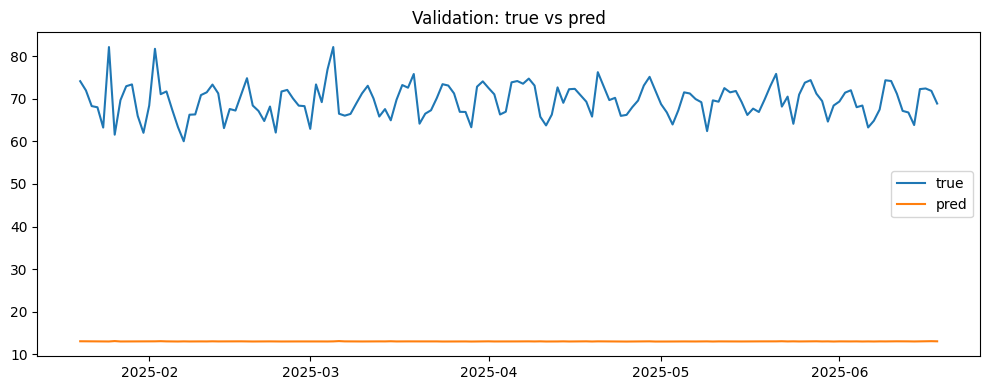

In [11]:
# 최종 예측 (val 전체)
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(Xva, dtype=torch.float32, device=device)).cpu().numpy().ravel()

if TASK=="regression":
    pred = logits
    true = yva.astype(float)
    print("MAE:", mean_absolute_error(true, pred), "RMSE:", rmse(true, pred))

    rep = pd.DataFrame({
        "time": tva,
        "y_true": true,
        "y_pred": pred,
        "abs_error": np.abs(true-pred)
    })
    print("=== abs_error Top 20 ===")
    display(rep.sort_values("abs_error", ascending=False).head(20))

    plt.figure(figsize=(10,4))
    plt.plot(rep["time"], rep["y_true"], label="true")
    plt.plot(rep["time"], rep["y_pred"], label="pred")
    plt.title("Validation: true vs pred")
    plt.legend(); plt.tight_layout(); plt.show()

else:
    y_prob = 1/(1+np.exp(-logits))
    y_true = yva.astype(int)

    print("PR-AUC:", average_precision_score(y_true, y_prob))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

    prec, rec, ths = precision_recall_curve(y_true, y_prob)
    f1s = 2*prec*rec/(prec+rec+1e-12)

    idx = np.argmax(f1s)
    th_f1 = ths[idx] if idx < len(ths) else 0.5
    th_top5 = np.percentile(y_prob, 95)

    TARGET_RECALL = 0.90
    valid = np.where(rec[:-1] >= TARGET_RECALL)[0]
    th_recall = th_f1
    if len(valid) > 0:
        idx_c = valid[np.argmax(prec[valid])]
        th_recall = ths[idx_c]

    def eval_at(th):
        y_pred = (y_prob >= th).astype(int)
        return {
            "threshold": float(th),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "alarm_rate": float(y_pred.mean())
        }

    print("F1-opt:", eval_at(th_f1))
    print("Top5% :", eval_at(th_top5))
    print("Recall>=%.2f:"%TARGET_RECALL, eval_at(th_recall))

    rep = pd.DataFrame({
        "time": tva,
        "score": y_prob,
        "y_true": y_true
    }).sort_values("score", ascending=False)

    print("=== score Top 30 ===")
    display(rep.head(30))


## 11) 실무 엔지니어 플레이북 (코드 스니펫 포함)

### A) 과적합(Train만 좋고 Val 나쁨)
- dropout↑, weight_decay↑
- hidden 줄이기 / epoch 줄이기
- lookback 너무 길면 줄이기(30→14)

### B) 이벤트(양성) 놓침(Recall 낮음)
- `pos_weight` 증가(자동으로 반영됨)
- threshold 낮추기 / Recall 고정 정책 사용
- `BINARY_LABEL_MODE="window_any"`로 라벨을 완화(윈도우 중 발생하면 1)

### C) 피크 구간만 계속 틀림(회귀에서 상위 구간 중요)
- Top-N 구간 MAE만 따로 평가
- 피크 구간 샘플 가중치로 학습

### D) 개념 드리프트(라인 변경/계절 변화)
- 최근 구간만 학습(최근 N일)
- 최근일수록 가중치↑


In [12]:
# (회귀) Top-N 구간 MAE
def topk_mae(y_true, y_pred, top_pct=5):
    y_true=np.asarray(y_true); y_pred=np.asarray(y_pred)
    th=np.percentile(y_true, 100-top_pct)
    mask=y_true>=th
    return mean_absolute_error(y_true[mask], y_pred[mask])

if TASK=="regression":
    print("Top5% MAE:", topk_mae(true, pred, 5))

# (이진) 라벨 모드 변경 팁
# BINARY_LABEL_MODE = "window_any"  # 윈도우 내 이벤트면 1로 완화해 Recall 개선 가능


Top5% MAE: 65.22523676380904
